In [1]:
import pandas as pd
import ir_datasets as irds
from ir_measures import read_trec_qrels
from ir_measures import * 
from ir_measures import evaluator
import pyterrier as pt
from scipy.stats import ttest_ind
import os
from os import path as path
from tqdm.auto import tqdm
import rbo

/opt/miniconda3/envs/annotate/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Ingestion

In [2]:
DIR = '../..' # if this breaks replace with a full path to the repo

DATASET = "msmarco-passage/trec-dl-2019/judged"
qrel_directory = f'{DIR}/judgments/main/qrels/'
annotation_directory = f'{DIR}/judgments/main/doccano/'

In [3]:
dataset = irds.load(DATASET)
original_qrels = pd.DataFrame(dataset.qrels_iter())

In [4]:
original_qrels

,query_id,doc_id,relevance,iteration
0,19335,1017759,0,Q0
1,19335,1082489,0,Q0
2,19335,109063,0,Q0
3,19335,1160863,0,Q0
4,19335,1160871,0,Q0
...,...,...,...,...
9255,1133167,8839920,2,Q0
9256,1133167,8839922,2,Q0
9257,1133167,944810,0,Q0
9258,1133167,949411,0,Q0


In [5]:
all_qrels = []
for file in os.listdir(qrel_directory):
    print(file)
    if file.endswith('.txt'):
        qrels = pd.DataFrame(read_trec_qrels(qrel_directory + file))
        annotator = file.replace('.txt', '').replace('-qrels', '')
        qrels['annotator'] = annotator
        all_qrels.append(qrels)

all_qrels = pd.concat(all_qrels)

andrew-parry-qrels.txt
ferdinand-schlatt-qrels.txt
froebe-qrels.txt
guglielmo-faggioli-qrels.txt
harry-scells-qrels.txt
saber-zerhoudi-qrels.txt
sean-macavaney-qrels.txt
eugene-yang-qrels.txt


In [6]:
all_comments = []
for file in os.listdir(annotation_directory):
    if file.endswith('.jsonl'):
        comments = pd.read_json(annotation_directory + file, lines=True)
        annotator = file.replace('.jsonl', '')
        comments['annotator'] = annotator
        # filter in case that comments 'Comments' column is an empty list
        comments = comments[comments['Comments'].apply(lambda x: len(x) > 0)]
        all_comments.append(comments)

all_comments = pd.concat(all_comments)[['text', 'annotator', 'label', 'Comments']]
all_comments['label'] = all_comments['label'].apply(lambda x: x[0])

In [7]:
RUN_DIR = f'{DIR}/runs/trec-dl-2019'
runs = {}
for run in os.listdir(RUN_DIR):
    #if 'dl-19-official' in run: continue 
    frame = pt.io.read_results(path.join(RUN_DIR, run)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
    frame['pool'] = 'dl-19-official' in run
    runs[run] = frame

# Qrel Pooling

In [8]:
query_groups = all_qrels.groupby('annotator')['query_id'].apply(set).reset_index()

# Step 2: Rename the column to 'queries'
query_groups.rename(columns={'query_id': 'queries'}, inplace=True)
query_groups = query_groups.set_index("annotator").queries.to_dict()

In [9]:
all_qrels

,query_id,doc_id,relevance,iteration,annotator
0,855410,8651770,2,0,andrew-parry
1,855410,8651771,2,0,andrew-parry
2,855410,8651772,1,0,andrew-parry
3,855410,8651775,3,0,andrew-parry
4,146187,1230566,1,0,andrew-parry
...,...,...,...,...,...
1110,1114646,3915244,0,0,eugene-yang
1111,168216,4713638,0,0,eugene-yang
1112,168216,1696466,0,0,eugene-yang
1113,168216,4245224,0,0,eugene-yang


In [10]:
all_qrels['queries'] = all_qrels['annotator'].map(lambda x : query_groups[x])
all_qrels['query_tuple'] = all_qrels['queries'].apply(lambda x : tuple(list(x)))
# Create a mapping of each unique tuple to a unique number
unique_queries = {tuple_queries: idx for idx, tuple_queries in enumerate(all_qrels['query_tuple'].unique())}
print(unique_queries)
# Assign the unique number to a new column
all_qrels['query_group_number'] = all_qrels['query_tuple'].map(lambda x : unique_queries[x])

{('573724', '489204', '490595', '156493', '451602', '130510', '855410', '1133167', '168216', '1114646', '1110199', '87452', '146187'): 0, ('1129237', '527433', '87181', '1121402', '1124210', '264014', '168216', '148538', '359349'): 1, ('47923', '915593', '833860', '962179', '168216', '183378', '19335', '104861', '1114819'): 2, ('1113437', '1037798', '1115776', '182539', '405717', '1112341', '131843', '1103812', '1063750', '1121709', '168216', '1117099', '1106007', '443396', '207786'): 3}


In [11]:
all_qrels.columns

Index(['query_id', 'doc_id', 'relevance', 'iteration', 'annotator', 'queries',
       'query_tuple', 'query_group_number'],
      dtype='object')

In [12]:
all_qrels

,query_id,doc_id,relevance,iteration,annotator,queries,query_tuple,query_group_number
0,855410,8651770,2,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
1,855410,8651771,2,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
2,855410,8651772,1,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
3,855410,8651775,3,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
4,146187,1230566,1,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
...,...,...,...,...,...,...,...,...
1110,1114646,3915244,0,0,eugene-yang,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
1111,168216,4713638,0,0,eugene-yang,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
1112,168216,1696466,0,0,eugene-yang,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
1113,168216,4245224,0,0,eugene-yang,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0


In [13]:
annotator_idx = all_qrels.drop_duplicates(["annotator", "query_tuple"])

In [14]:
annotator_idx = annotator_idx.set_index('annotator').query_tuple.to_dict()

In [15]:
import pandas as pd
import itertools

# Assuming your dataframe is named 'df'

# Group by 'query_group_number' and collect unique annotators
grouped_annotators = all_qrels.groupby('query_group_number')['annotator'].unique().to_dict()

# Create a list of all possible combinations of annotators for each group
combinations = [
    [annotators[0], annotators[1]]
    for annotators in grouped_annotators.values()
]

# Create a list of all possible combinations across groups
all_combinations = [
    comb for comb in itertools.product(*combinations)
]

# Iterate through each combination and concatenate the corresponding data
combinations = {}
for comb in all_combinations:
    combinations[tuple(comb)] = pd.concat([all_qrels[all_qrels['annotator'] == annotator] for annotator in comb])[['query_id', 'doc_id', 'relevance']]
    # Process the concatenated_df as needed (e.g., save it, analyze it)

In [16]:
all_qrels

,query_id,doc_id,relevance,iteration,annotator,queries,query_tuple,query_group_number
0,855410,8651770,2,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
1,855410,8651771,2,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
2,855410,8651772,1,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
3,855410,8651775,3,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
4,146187,1230566,1,0,andrew-parry,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
...,...,...,...,...,...,...,...,...
1110,1114646,3915244,0,0,eugene-yang,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
1111,168216,4713638,0,0,eugene-yang,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
1112,168216,1696466,0,0,eugene-yang,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0
1113,168216,4245224,0,0,eugene-yang,"{573724, 489204, 490595, 156493, 451602, 13051...","(573724, 489204, 490595, 156493, 451602, 13051...",0


# Evaluation

In [17]:
metrics = [AP(rel=2), NDCG(cutoff=10), R(rel=2)@100, P(rel=2, cutoff=10), RR(rel=2), RR(rel=2, cutoff=10)]

In [18]:
original_evaluator = evaluator(metrics, qrels=original_qrels)

## Per Annotator Performance

In [19]:
out = {
    'annotators' : [],
    'run' : [],
    'metric' : [],
    'value' : [],
}
progress = tqdm(total=len(combinations) * len(runs))
for annotators, qrels in combinations.items():
    eval = evaluator(metrics, qrels=qrels)
    for name, run in runs.items():
        progress.update(1)
        measure = eval.calc_aggregate(run)
        measure = {str(k) : v for k, v in measure.items()}
        for k, v in measure.items():
            out['annotators'].append(annotators)
            out['run'].append(name)
            out['metric'].append(k)
            out['value'].append(v)

100%|█████████▉| 975/976 [04:38<00:00, 16.71it/s]

In [20]:
out = pd.DataFrame(out)

In [21]:
out.columns

Index(['annotators', 'run', 'metric', 'value'], dtype='object')

## Original Order

In [22]:
original_performance = {
    'run' : [],
    'metric' : [],
    'value' : [],
}
progress = tqdm(total=len(runs))
for name, run in runs.items():
    progress.update(1)
    measure = original_evaluator.calc_aggregate(run)
    measure = {str(k) : v for k, v in measure.items()}
    for k, v in measure.items():
        original_performance['run'].append(name)
        original_performance['metric'].append(k)
        original_performance['value'].append(v)
original_performance = pd.DataFrame(original_performance)


100%|██████████| 976/976 [04:38<00:00,  3.50it/s]

 98%|█████████▊| 60/61 [00:17<00:00, 16.82it/s]

## Comparison

In [23]:
grouped_data = out.groupby("annotators")
metric_variances = {}
for annotators, group in grouped_data:
    metric_variances[annotators] = {}
    for metric, subgroup in group.groupby("metric"):
        metric_variances[annotators][metric] = subgroup["value"].var()

In [24]:
system_grouped_data = out.groupby("run")
system_metric_variances = {}
for run, group in system_grouped_data:
    system_metric_variances[run] = {}
    for metric, subgroup in group.groupby("metric"):
        system_metric_variances[run][metric] = subgroup["value"].var()

In [25]:
out

,annotators,run,metric,value
0,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,R(rel=2)@100,0.753531
1,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,AP(rel=2),0.538348
2,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,P(rel=2)@10,0.648837
3,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,RR(rel=2)@10,0.879845
4,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,nDCG@10,0.710126
...,...,...,...,...
5851,"(eugene-yang, froebe, harry-scells, sean-macav...",tirex_set-encoder-large_msmarco-passage-trec-d...,AP(rel=2),0.380717
5852,"(eugene-yang, froebe, harry-scells, sean-macav...",tirex_set-encoder-large_msmarco-passage-trec-d...,P(rel=2)@10,0.488372
5853,"(eugene-yang, froebe, harry-scells, sean-macav...",tirex_set-encoder-large_msmarco-passage-trec-d...,RR(rel=2)@10,0.735465
5854,"(eugene-yang, froebe, harry-scells, sean-macav...",tirex_set-encoder-large_msmarco-passage-trec-d...,nDCG@10,0.642163


In [26]:
rbo_values = {annotator : {} for annotator in out.annotators.unique().tolist()}
system_order_changes = {annotator : {} for annotator in out.annotators.unique().tolist()}
system_rankings = {system : {annotator : {} for annotator in out.annotators.unique().tolist()} for system in out.run.unique().tolist()}
for annotator, group in out.groupby("annotators"):
    print(annotator)
    for metric, subgroup in group.groupby("metric"):
        original_subset = original_performance[original_performance['metric']==metric].sort_values(by='value', ascending=False).run.to_list()
        system_order_1 = subgroup.sort_values(by='value', ascending=False).run.to_list()
        system_order_2 = original_subset
        system_order_changes[annotator][metric] = system_order_1
        val = rbo.RankingSimilarity(system_order_1, system_order_2).rbo()
        rbo_values[annotator][metric] = val

        for rank, system in enumerate(system_order_1):
            system_rankings[system][annotator][metric] = rank + 1
        

('andrew-parry', 'ferdinand-schlatt', 'guglielmo-faggioli', 'saber-zerhoudi')
('andrew-parry', 'ferdinand-schlatt', 'guglielmo-faggioli', 'sean-macavaney')
('andrew-parry', 'ferdinand-schlatt', 'harry-scells', 'saber-zerhoudi')
('andrew-parry', 'ferdinand-schlatt', 'harry-scells', 'sean-macavaney')
('andrew-parry', 'froebe', 'guglielmo-faggioli', 'saber-zerhoudi')
('andrew-parry', 'froebe', 'guglielmo-faggioli', 'sean-macavaney')
('andrew-parry', 'froebe', 'harry-scells', 'saber-zerhoudi')
('andrew-parry', 'froebe', 'harry-scells', 'sean-macavaney')
('eugene-yang', 'ferdinand-schlatt', 'guglielmo-faggioli', 'saber-zerhoudi')
('eugene-yang', 'ferdinand-schlatt', 'guglielmo-faggioli', 'sean-macavaney')
('eugene-yang', 'ferdinand-schlatt', 'harry-scells', 'saber-zerhoudi')
('eugene-yang', 'ferdinand-schlatt', 'harry-scells', 'sean-macavaney')
('eugene-yang', 'froebe', 'guglielmo-faggioli', 'saber-zerhoudi')
('eugene-yang', 'froebe', 'guglielmo-faggioli', 'sean-macavaney')
('eugene-yang', 

In [27]:
# Initialize the dictionaries
rbo_values = {annotator: {} for annotator in out.annotators.unique().tolist()}
system_order_changes = {annotator: {} for annotator in out.annotators.unique().tolist()}
system_rank_deltas = {system: {annotator: {} for annotator in out.annotators.unique().tolist()} for system in out.run.unique().tolist()}

# Loop over annotators and group by 'annotators'
for annotator, group in out.groupby("annotators"):    
    # Loop over each metric within the annotator group
    for metric, subgroup in group.groupby("metric"):
        
        # Get the original system order for the metric
        original_subset = original_performance[original_performance['metric'] == metric].sort_values(by='value', ascending=False).run.to_list()
        
        # Get the current system order for this annotator and metric
        system_order_1 = subgroup.sort_values(by='value', ascending=False).run.to_list()
        system_order_2 = original_subset
        
        # Track the system ranking changes for this annotator and metric
        system_order_changes[annotator][metric] = system_order_1
        
        # Calculate RBO value for the ranking comparison
        val = rbo.RankingSimilarity(system_order_1, system_order_2).rbo()
        rbo_values[annotator][metric] = val
        
        # Calculate the rank delta for each system
        for system in system_order_1:
            # Get the position in system_order_1 and system_order_2
            rank_in_new_order = system_order_1.index(system) + 1  # Adding 1 to make it 1-based index
            rank_in_original_order = system_order_2.index(system) + 1
            # Calculate the delta
            delta = rank_in_new_order - rank_in_original_order
            
            # Store the delta in the system_rank_deltas dictionary
            system_rank_deltas[system][annotator][metric] = delta


In [83]:
original_performance['annotators'] = [('original',)]*len(original_performance)

In [87]:
combined = pd.concat([out, original_performance])[['annotators', 'run', 'metric', 'value']]

In [88]:
combined

,annotators,run,metric,value
0,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,R(rel=2)@100,0.753531
1,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,AP(rel=2),0.538348
2,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,P(rel=2)@10,0.648837
3,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,RR(rel=2)@10,0.879845
4,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,nDCG@10,0.710126
...,...,...,...,...
361,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,AP(rel=2),0.377025
362,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,P(rel=2)@10,0.651163
363,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,RR(rel=2)@10,0.844961
364,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,nDCG@10,0.727026


In [93]:
def model_type(name):
    if "gpt" in name or "zephyr" in name: return "LLM"
    elif "srchvrs" in name: return "Lexical"
    elif "bm25exp_marcomb" in name: return "Neural"
    elif "bm25_marcomb" in name: return "Neural"
    elif "dct_qp_bm25e" in name: return "Neural"
    elif "dct_tp_bm25e" in name: return "Neural"
    elif "bm25" in name: return "Lexical"
    elif "baseline" in name: return "Lexical"
    else: return "Neural"
    

In [94]:
combined["Model Type"] = combined.run.map(lambda x : model_type(x))

In [95]:
combined

,annotators,run,metric,value,Model Type
0,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,R(rel=2)@100,0.753531,Neural
1,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,AP(rel=2),0.538348,Neural
2,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,P(rel=2)@10,0.648837,Neural
3,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,RR(rel=2)@10,0.879845,Neural
4,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,nDCG@10,0.710126,Neural
...,...,...,...,...,...
361,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,AP(rel=2),0.377025,Neural
362,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,P(rel=2)@10,0.651163,Neural
363,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,RR(rel=2)@10,0.844961,Neural
364,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,nDCG@10,0.727026,Neural


In [96]:
combined['Original'] = combined['annotators'].map(lambda x : len(x) < 2)

In [97]:
combined

,annotators,run,metric,value,Model Type,Original
0,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,R(rel=2)@100,0.753531,Neural,False
1,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,AP(rel=2),0.538348,Neural,False
2,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,P(rel=2)@10,0.648837,Neural,False
3,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,RR(rel=2)@10,0.879845,Neural,False
4,"(andrew-parry, ferdinand-schlatt, guglielmo-fa...",colbert_monoelectra-base_msmarco-passage-trec-...,nDCG@10,0.710126,Neural,False
...,...,...,...,...,...,...
361,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,AP(rel=2),0.377025,Neural,True
362,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,P(rel=2)@10,0.651163,Neural,True
363,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,RR(rel=2)@10,0.844961,Neural,True
364,"(original,)",tirex_set-encoder-large_msmarco-passage-trec-d...,nDCG@10,0.727026,Neural,True


/tmp/ipykernel_10613/1679473449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_non_original['Original'] = False
/tmp/ipykernel_10613/1679473449.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_non_original['Model Type'] = aggregated_non_original.run.map(lambda x : model_type(x))
/tmp/ipykernel_10613/1679473449.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

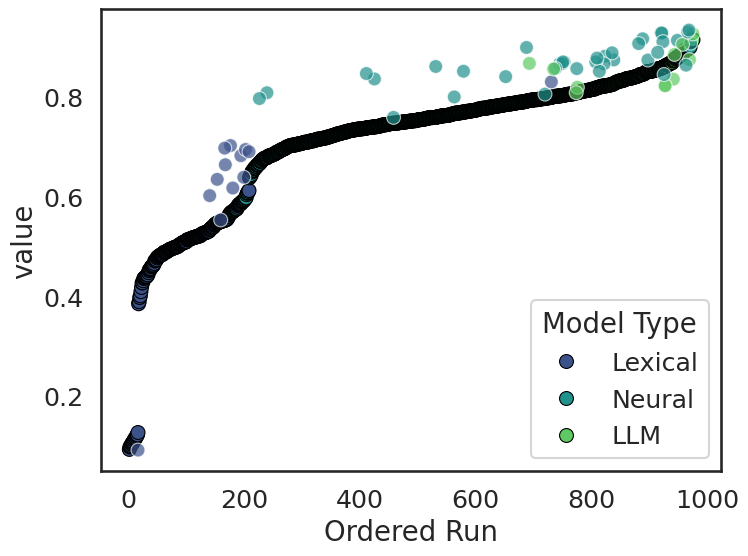

In [149]:
METRIC = 'RR(rel=2)@10'  # You can dynamically change this to any metric column name
data=combined.copy()
data = data[data['metric']==METRIC]

# Step 1: Aggregate the non-original runs by the specified metric (e.g., mean)

aggregated_non_original = data[data['Original'] == False]
aggregated_non_original['Original'] = False
aggregated_non_original['Model Type'] = aggregated_non_original.run.map(lambda x : model_type(x))

# Step 2: Sort non-original aggregated data by the metric and assign ordered run
sorted_aggregated = aggregated_non_original.sort_values(by='value').reset_index(drop=True)
sorted_aggregated['Ordered Run'] = range(1, len(sorted_aggregated) + 1)

# Step 3: Assign ordered run for the original runs, without merging
original = data[data['Original'] == True]
original['Ordered Run'] = original['run'].map(dict(zip(sorted_aggregated['run'], sorted_aggregated['Ordered Run'])))
# Step 4: Plot both non-original and original runs

plt.figure(figsize=(8,6))

# Plot aggregated non-original models first
sns.scatterplot(data=sorted_aggregated, 
                x='Ordered Run', y='value', hue='Model Type', 
                palette='viridis', s=100, edgecolor='black')

# Plot original models with transparency
sns.scatterplot(data=original, 
                x='Ordered Run', y='value', hue='Model Type', hue_order=['Lexical', 'Neural', 'LLM'],
                palette='viridis', s=100, alpha=0.7, legend=False)

# Show plot
plt.show()


/tmp/ipykernel_10613/1513538982.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Ordered Run'] = original['run'].map(dict(zip(sorted_non_original['run'], sorted_non_original['Ordered Run'])))


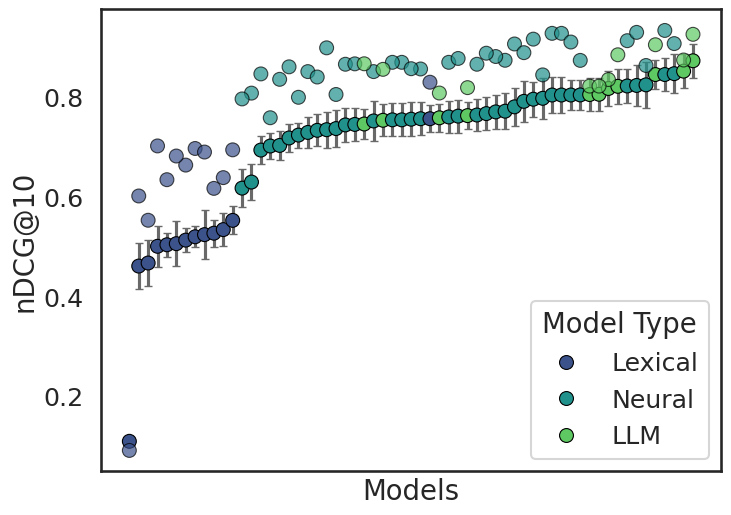

In [150]:
# Step 1: Calculate the mean and standard deviation for the non-original runs per 'Run'
non_original_stats = data[data['Original'] == False].groupby('run')['value'].agg(['mean', 'std']).reset_index()

# Step 2: Keep the original runs as they are
original = data[data['Original'] == True]

# Step 3: Sort non-original runs by the metric (mean value) and assign an order
sorted_non_original = non_original_stats.sort_values(by='mean').reset_index(drop=True)
sorted_non_original['Ordered Run'] = range(1, len(sorted_non_original) + 1)
sorted_non_original['Model Type'] = sorted_non_original.run.map(lambda x : model_type(x))

# Step 4: Assign the same order to original runs (using the run order of the non-original runs)
original['Ordered Run'] = original['run'].map(dict(zip(sorted_non_original['run'], sorted_non_original['Ordered Run'])))

# Plot
plt.figure(figsize=(8,6))

# Adding error bars
plt.errorbar(x=sorted_non_original['Ordered Run'], 
             y=sorted_non_original['mean'], 
             yerr=sorted_non_original['std'], 
             fmt='none', ecolor='dimgrey', capsize=3, zorder=1)

# Plot non-original runs with error bars (std)
sns.scatterplot(data=sorted_non_original, 
                x='Ordered Run', y='mean', hue='Model Type', palette='viridis', s=100, edgecolor='black', legend=True, zorder=2)

# Plot original models with transparency
sns.scatterplot(data=original, 
                x='Ordered Run', y='value', hue='Model Type', hue_order=['Lexical', 'Neural', 'LLM'],
                palette='viridis', s=100, edgecolor='black', alpha=0.7, legend=False, zorder=2)
# Set axis labels
plt.xlabel('Models')
plt.ylabel('nDCG@10')

# Remove x ticks
plt.xticks([])
# Show plot
plt.show()

In [42]:
import re

def maintain_special_capitalization(name):
    special_terms = ['BM25', 'RM3', 'BERT', 'ICT', 'CKNRM', 'TUA', 'TUW', 'UNH', 'AX', 'PRF', 'IDST', 'MS', 'DUET']
    for term in special_terms:
        name = re.sub(rf'\b{term}\b', term, name, flags=re.IGNORECASE)
    return name

def clean_model_name(model):
    # Clean up specific model names
    model = model.replace('monoelectra', 'MonoELECTRA')
    model = model.replace('rankgpt', 'RankGPT')
    model = model.replace('rankzephyr', 'RankZephyr')
    model = re.sub(r'set-encoder', 'SetEncoder', model, flags=re.IGNORECASE)
    model = model.replace('-base', ' Base')
    model = model.replace('-large', ' Large')
    model = model.replace('-full', ' Full')
    model = model.replace('-turbo', ' Turbo')
    return maintain_special_capitalization(model)

def clean_system_name(name):
    # Remove file extensions
    name = re.sub(r'\.(run|txt|gz)$', '', name)
    
    # Remove references to dl19 dataset
    name = re.sub(r'dl-19-official-input\.', '', name)
    name = re.sub(r'msmarco-passage-trec-dl-2019-judged', '', name)
    
    # Handle ColBERT re-ranking cases
    if name.startswith('colbert_'):
        model = name.split('_')[1]
        return f"ColBERT >> {clean_model_name(model)}"
    
    # Handle tirex cases similar to ColBERT
    if name.startswith('tirex_'):
        return clean_model_name(name.replace('tirex_', ''))
    
    # Handle maik-froebe cases
    if name.startswith('maik-froebe-'):
        return clean_model_name(name.replace('maik-froebe-', ''))
    
    # Clean up remaining names
    name = name.replace('_', ' ').replace('-', ' ')
    name = ' '.join(word.capitalize() for word in name.split())
    return maintain_special_capitalization(name)

# Test the function with your provided names
system_names = [
    'colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run',
    'colbert_rankgpt4-turbo_msmarco-passage-trec-dl-2019-judged.run',
    'dl-19-official-input.ICT-BERT2.gz',
    'dl-19-official-input.bm25tuned_rm3_p.gz',
    'maik-froebe-colbert-run.txt',
    'tirex_set-encoder-large_msmarco-passage-trec-dl-2019-judged.run',
    'dl-19-official-input.UNH_bm25.gz',
    'dl-19-official-input.ms_duet_passage.gz'
]

for name in system_names:
    print(f"Original: {name}")
    print(f"Cleaned:  {clean_system_name(name)}")
    print()

Original: colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run
Cleaned:  ColBERT >> MonoELECTRA Base

Original: colbert_rankgpt4-turbo_msmarco-passage-trec-dl-2019-judged.run
Cleaned:  ColBERT >> RankGPT4 Turbo

Original: dl-19-official-input.ICT-BERT2.gz
Cleaned:  ICT Bert2

Original: dl-19-official-input.bm25tuned_rm3_p.gz
Cleaned:  Bm25tuned RM3 P

Original: maik-froebe-colbert-run.txt
Cleaned:  colbert-run

Original: tirex_set-encoder-large_msmarco-passage-trec-dl-2019-judged.run
Cleaned:  SetEncoder Large_

Original: dl-19-official-input.UNH_bm25.gz
Cleaned:  UNH BM25

Original: dl-19-official-input.ms_duet_passage.gz
Cleaned:  MS DUET Passage



In [43]:
list(system_rank_deltas.keys())

['colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run',
 'colbert_monoelectra-large_msmarco-passage-trec-dl-2019-judged.run',
 'colbert_rankgpt4-turbo_msmarco-passage-trec-dl-2019-judged.run',
 'colbert_rankgpt4_msmarco-passage-trec-dl-2019-judged.run',
 'colbert_rankgpt4o-full_msmarco-passage-trec-dl-2019-judged.run',
 'colbert_rankgpt4o_msmarco-passage-trec-dl-2019-judged.run',
 'colbert_rankzephyr_msmarco-passage-trec-dl-2019-judged.run',
 'colbert_set-encoder-base_msmarco-passage-trec-dl-2019-judged.run',
 'colbert_set-encoder-large_msmarco-passage-trec-dl-2019-judged.run',
 'dl-19-official-input.ICT-BERT2.gz',
 'dl-19-official-input.ICT-CKNRM_B.gz',
 'dl-19-official-input.ICT-CKNRM_B50.gz',
 'dl-19-official-input.TUA1-1.gz',
 'dl-19-official-input.TUW19-p1-f.gz',
 'dl-19-official-input.TUW19-p1-re.gz',
 'dl-19-official-input.TUW19-p2-f.gz',
 'dl-19-official-input.TUW19-p2-re.gz',
 'dl-19-official-input.TUW19-p3-f.gz',
 'dl-19-official-input.TUW19-p3-re.gz',
 'dl-19-of

In [46]:
system_name_mapping = {
    'colbert_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run': 'ColBERT >> MonoELECTRA Base',
    'colbert_monoelectra-large_msmarco-passage-trec-dl-2019-judged.run': 'ColBERT >> MonoELECTRA Large',
    'colbert_rankgpt4-turbo_msmarco-passage-trec-dl-2019-judged.run': 'ColBERT >> RankGPT4 Turbo',
    'colbert_rankgpt4_msmarco-passage-trec-dl-2019-judged.run': 'ColBERT >> RankGPT4',
    'colbert_rankgpt4o-full_msmarco-passage-trec-dl-2019-judged.run': 'ColBERT >> RankGPT4O Full',
    'colbert_rankgpt4o_msmarco-passage-trec-dl-2019-judged.run': 'ColBERT >> RankGPT4O',
    'colbert_rankzephyr_msmarco-passage-trec-dl-2019-judged.run': 'ColBERT >> RankZephyr',
    'colbert_set-encoder-base_msmarco-passage-trec-dl-2019-judged.run': 'ColBERT >> SetEncoder Base',
    'colbert_set-encoder-large_msmarco-passage-trec-dl-2019-judged.run': 'ColBERT >> SetEncoder Large',
    'dl-19-official-input.ICT-BERT2.gz': 'ICT-BERT2',
    'dl-19-official-input.ICT-CKNRM_B.gz': 'ICT-CKNRM B',
    'dl-19-official-input.ICT-CKNRM_B50.gz': 'ICT-CKNRM B50',
    'dl-19-official-input.TUA1-1.gz': 'TUA1-1',
    'dl-19-official-input.TUW19-p1-f.gz': 'TUW19 P1 F',
    'dl-19-official-input.TUW19-p1-re.gz': 'TUW19 P1 RE',
    'dl-19-official-input.TUW19-p2-f.gz': 'TUW19 P2 F',
    'dl-19-official-input.TUW19-p2-re.gz': 'TUW19 P2 RE',
    'dl-19-official-input.TUW19-p3-f.gz': 'TUW19 P3 F',
    'dl-19-official-input.TUW19-p3-re.gz': 'TUW19 P3 RE',
    'dl-19-official-input.UNH_bm25.gz': 'UNH BM25',
    'dl-19-official-input.UNH_exDL_bm25.gz': 'UNH ExDL BM25',
    'dl-19-official-input.bm25base_ax_p.gz': 'BM25 Base AX P',
    'dl-19-official-input.bm25base_p.gz': 'BM25 Base P',
    'dl-19-official-input.bm25base_prf_p.gz': 'BM25 Base PRF P',
    'dl-19-official-input.bm25base_rm3_p.gz': 'BM25 Base RM3 P',
    'dl-19-official-input.bm25tuned_ax_p.gz': 'BM25 Tuned AX P',
    'dl-19-official-input.bm25tuned_p.gz': 'BM25 Tuned P',
    'dl-19-official-input.bm25tuned_prf_p.gz': 'BM25 Tuned PRF P',
    'dl-19-official-input.bm25tuned_rm3_p.gz': 'BM25 Tuned RM3 P',
    'dl-19-official-input.idst_bert_p1.gz': 'IDST BERT P1',
    'dl-19-official-input.idst_bert_p2.gz': 'IDST BERT P2',
    'dl-19-official-input.idst_bert_p3.gz': 'IDST BERT P3',
    'dl-19-official-input.idst_bert_pr1.gz': 'IDST BERT PR1',
    'dl-19-official-input.idst_bert_pr2.gz': 'IDST BERT PR2',
    'dl-19-official-input.ms_duet_passage.gz': 'MS DUET Passage',
    'dl-19-official-input.p_bert.gz': 'P BERT',
    'dl-19-official-input.p_exp_bert.gz': 'P Exp BERT',
    'dl-19-official-input.p_exp_rm3_bert.gz': 'P Exp RM3 BERT',
    'dl-19-official-input.runid2.gz': 'Run ID 2',
    'dl-19-official-input.runid3.gz': 'Run ID 3',
    'dl-19-official-input.runid4.gz': 'Run ID 4',
    'dl-19-official-input.runid5.gz': 'Run ID 5',
    'dl-19-official-input.srchvrs_ps_run1.gz': 'Srchvrs PS Run 1',
    'dl-19-official-input.srchvrs_ps_run2.gz': 'Srchvrs PS Run 2',
    'dl-19-official-input.srchvrs_ps_run3.gz': 'Srchvrs PS Run 3',
    'dl-19-official-input.test1.gz': 'Test 1',
    'maik-froebe-colbert-run.txt': 'ColBERT',
    'maik-froebe-mono-t5-3b-run.txt': 'Mono T5 3B',
    'maik-froebe-mono-t5-base-run.txt': 'Mono T5 Base',
    'maik-froebe-rank-zephyr-run.txt': 'BM25 >> RankZephyr',
    'maik-froebe-sparse-cross-encoder-run.txt': 'BM25 >> Sparse Cross-Encoder',
    'maik-froebe-splade-run.txt': 'SPLADE ED++',
    'tirex_monoelectra-base_msmarco-passage-trec-dl-2019-judged.run': 'BM25 >> MonoELECTRA Base',
    'tirex_monoelectra-large_msmarco-passage-trec-dl-2019-judged.run': 'BM25 >> MonoELECTRA Large',
    'tirex_rankgpt4-turbo_msmarco-passage-trec-dl-2019-judged.run': 'BM25 >> RankGPT4 Turbo',
    'tirex_rankgpt4_msmarco-passage-trec-dl-2019-judged.run': 'BM25 >> RankGPT4',
    'tirex_rankgpt4o-full_msmarco-passage-trec-dl-2019-judged.run': 'BM25 >> RankGPT4O Full',
    'tirex_rankgpt4o_msmarco-passage-trec-dl-2019-judged.run': 'BM25 >> RankGPT4O',
    'tirex_rankzephyr_msmarco-passage-trec-dl-2019-judged.run': 'BM25 >> RankZephyr',
    'tirex_set-encoder-base_msmarco-passage-trec-dl-2019-judged.run': 'BM25 >> SetEncoder Base',
    'tirex_set-encoder-large_msmarco-passage-trec-dl-2019-judged.run': 'BM25 >> SetEncoder Large'
}

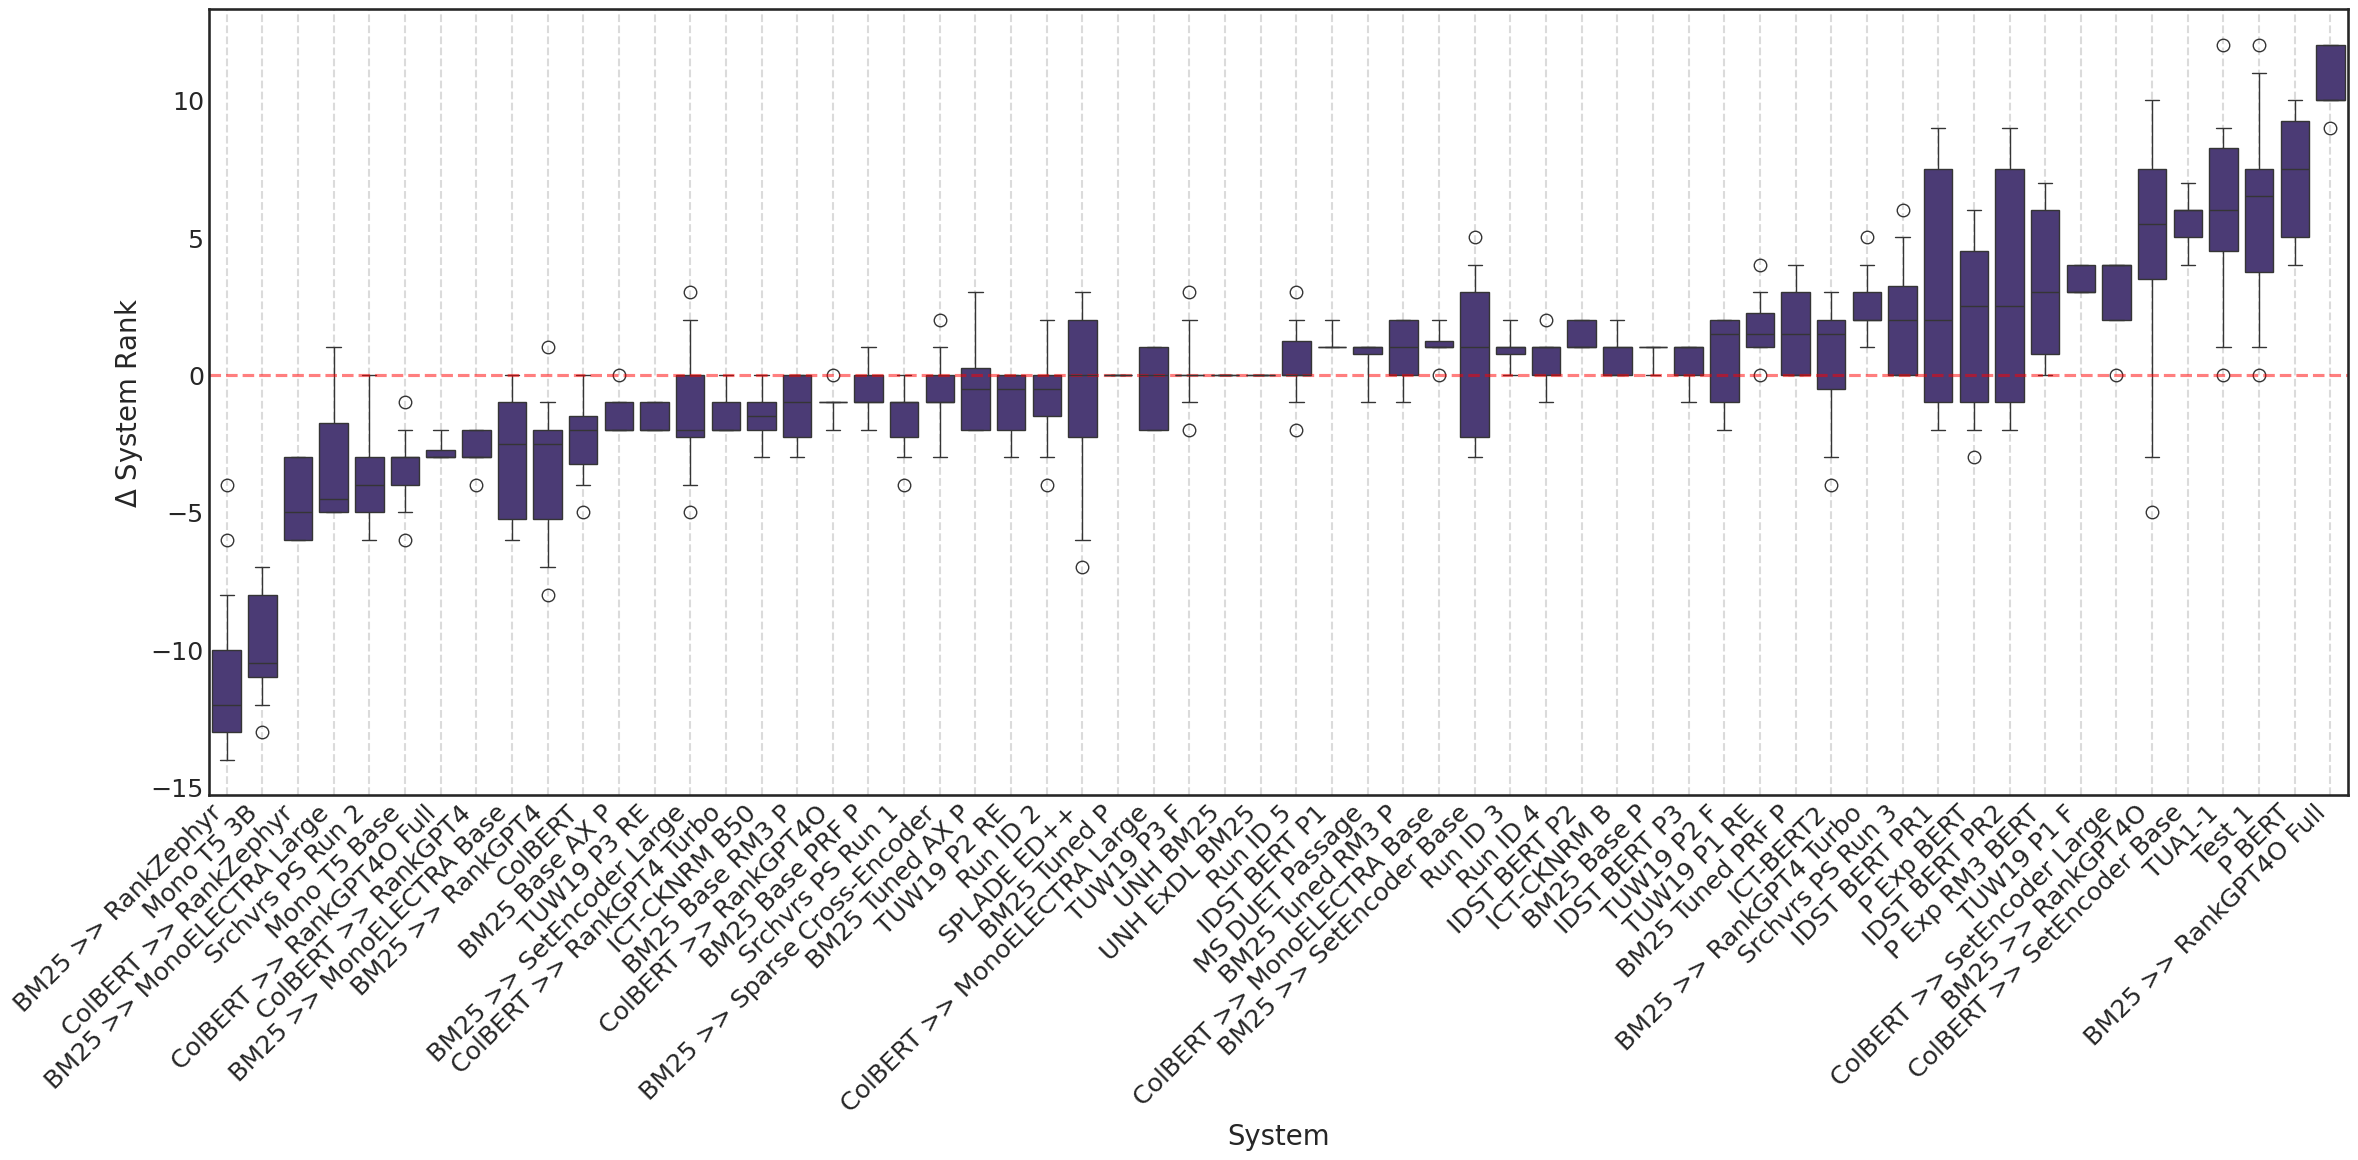

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the context to "talk" and adjust font scale
sns.set_theme(style="white", palette="viridis")
sns.set_context("talk", font_scale=1.1)

# Reshape the data
data = []
for system, annotators in system_rank_deltas.items():
    for annotator, metrics in annotators.items():
        if 'nDCG@10' in metrics and system in system_name_mapping.keys():
            data.append({
                'System': system_name_mapping[system],
                'Annotator': annotator,
                'Rank Delta': metrics['nDCG@10']
            })

df = pd.DataFrame(data)

# Sort the dataframe by median Rank Delta
df_sorted = df.groupby('System')['Rank Delta'].median().sort_values().index
df['System'] = pd.Categorical(df['System'], categories=df_sorted, ordered=True)

# Create the plot
plt.figure(figsize=(max(8, len(df['System'].unique()) * 0.4), 12))  # Adjust width based on number of systems
sns.boxplot(x='System', y='Rank Delta', data=df, whis=[5, 95])

# Customize the plot
plt.xlabel('System')
plt.ylabel('$\Delta$ System Rank')

# Add a horizontal line at y=0 to show no change
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tick_params(axis='x', which='both', direction='in', length=5, width=1, color='black')  # Control appearance of x-ticks
plt.tick_params(axis='y', which='both', direction='in', length=5, width=1, color='black')  # Control appearance of y-ticks

# Adjust layout to prevent cutting off labels
plt.tight_layout()
plt.savefig("plots/rank_changes.svg", format='svg')
# Show the plot
plt.show()

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Calculate average delta for each system across annotators for each metric
average_deltas = {}

for system in system_rank_deltas:
    for annotator in system_rank_deltas[system]:
        for metric, delta in system_rank_deltas[system][annotator].items():
            if metric not in average_deltas:
                average_deltas[metric] = {}
            if system not in average_deltas[metric]:
                average_deltas[metric][system] = []
            average_deltas[metric][system].append(delta)

# Step 2: Calculate the average delta per system for each metric
average_deltas_final = {
    metric: {system: sum(deltas) / len(deltas) for system, deltas in systems.items()}
    for metric, systems in average_deltas.items()
}

# Step 3: Convert data into a pandas DataFrame
# This will have columns: 'System', 'Metric', 'Average Delta'
data = []

for metric, systems in average_deltas_final.items():
    for system, avg_delta in systems.items():
        data.append([system, metric, avg_delta])

df = pd.DataFrame(data, columns=['System', 'Metric', 'Average Delta'])

# Step 4: Plot the bar charts for each metric
metrics = df['Metric'].unique()
'''
for metric in metrics:
    plt.figure(figsize=(10, 6))
    
    # Filter the data for the current metric
    subset = df[df['Metric'] == metric]
    
    # Create a seaborn barplot
    sns.barplot(data=subset, x='System', y='Average Delta', palette='viridis')
    
    # Add titles and labels
    plt.title(f'Average Rank Delta for Metric: {metric}')
    plt.xticks(rotation=90, ha='right')  # Rotate the system names for readability
    plt.xlabel('System')
    plt.ylabel('Average Delta')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
'''

"\nfor metric in metrics:\n    plt.figure(figsize=(10, 6))\n    \n    # Filter the data for the current metric\n    subset = df[df['Metric'] == metric]\n    \n    # Create a seaborn barplot\n    sns.barplot(data=subset, x='System', y='Average Delta', palette='viridis')\n    \n    # Add titles and labels\n    plt.title(f'Average Rank Delta for Metric: {metric}')\n    plt.xticks(rotation=90, ha='right')  # Rotate the system names for readability\n    plt.xlabel('System')\n    plt.ylabel('Average Delta')\n    \n    # Show the plot\n    plt.tight_layout()\n    plt.show()\n"

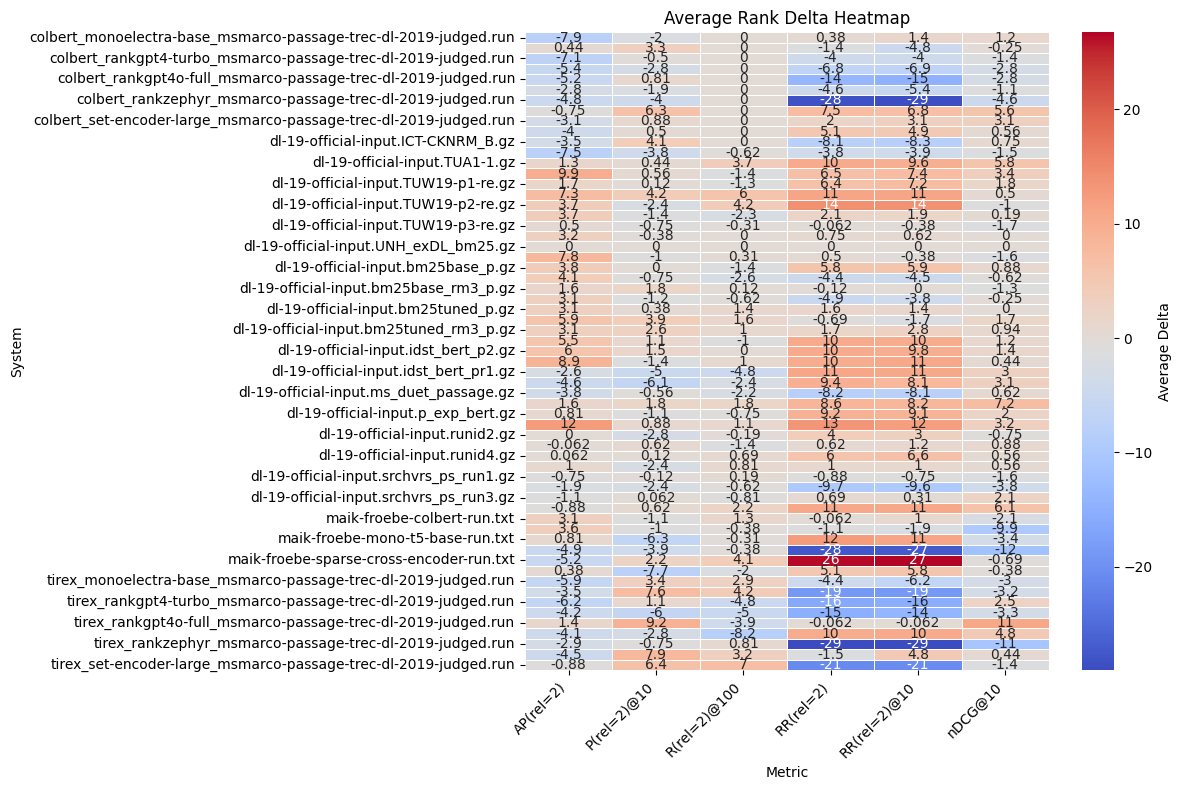

In [29]:
# Step 1: Pivot the DataFrame for heatmap
heatmap_data = df.pivot(index="System", columns="Metric", values="Average Delta")

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Average Delta'})

# Customize the plot
plt.title('Average Rank Delta Heatmap')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metric')
plt.ylabel('System')

# Show the plot
plt.tight_layout()
plt.savefig("plots/heat-delta.png")


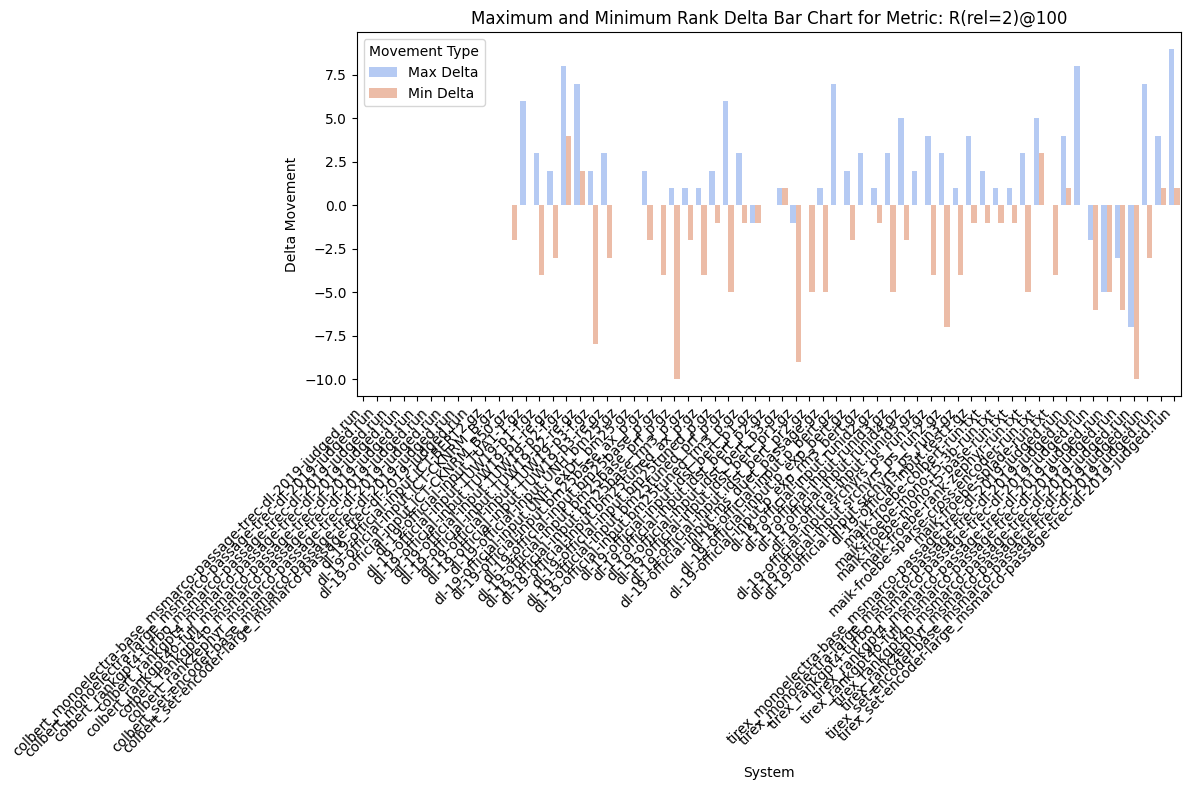

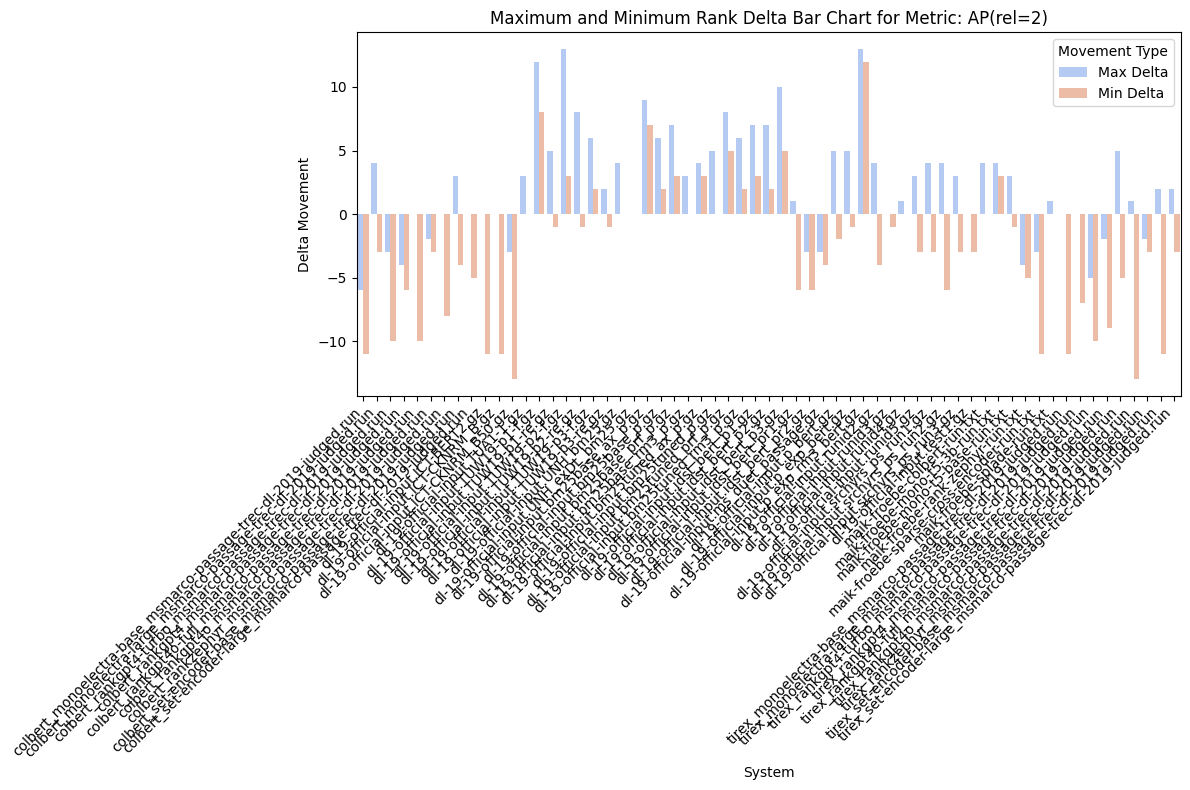

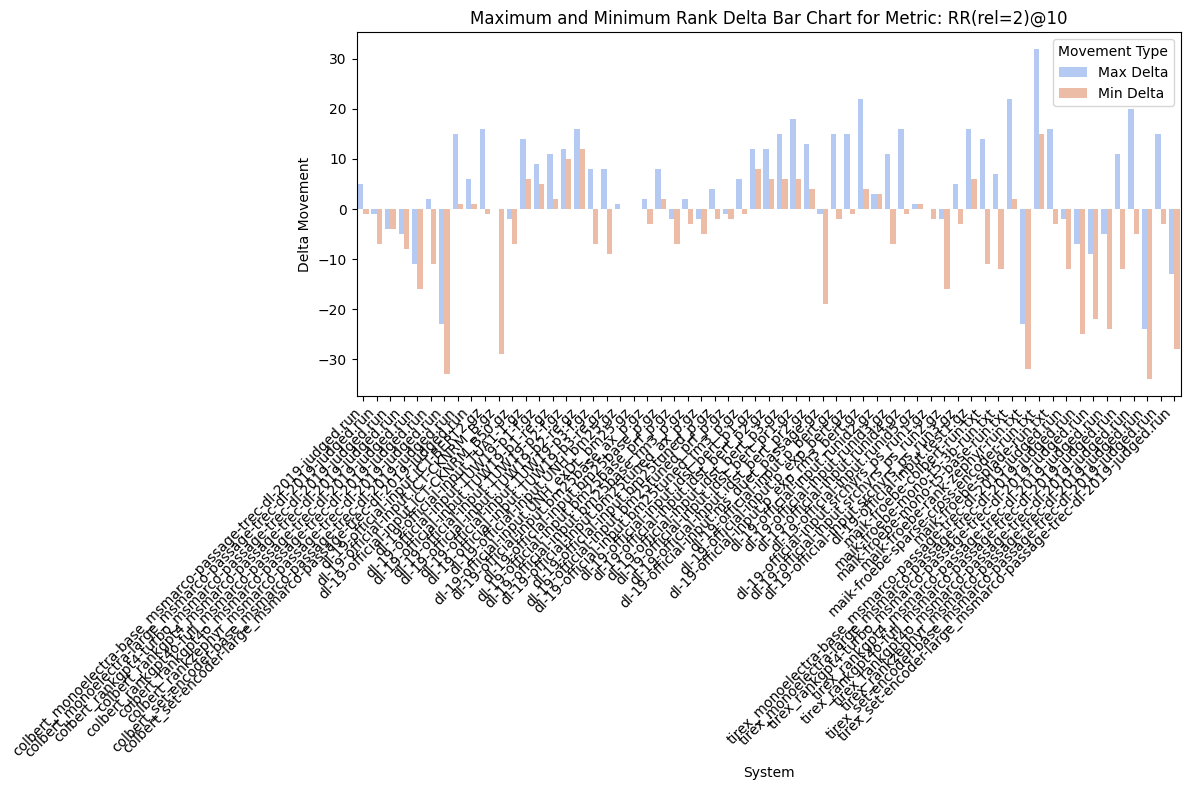

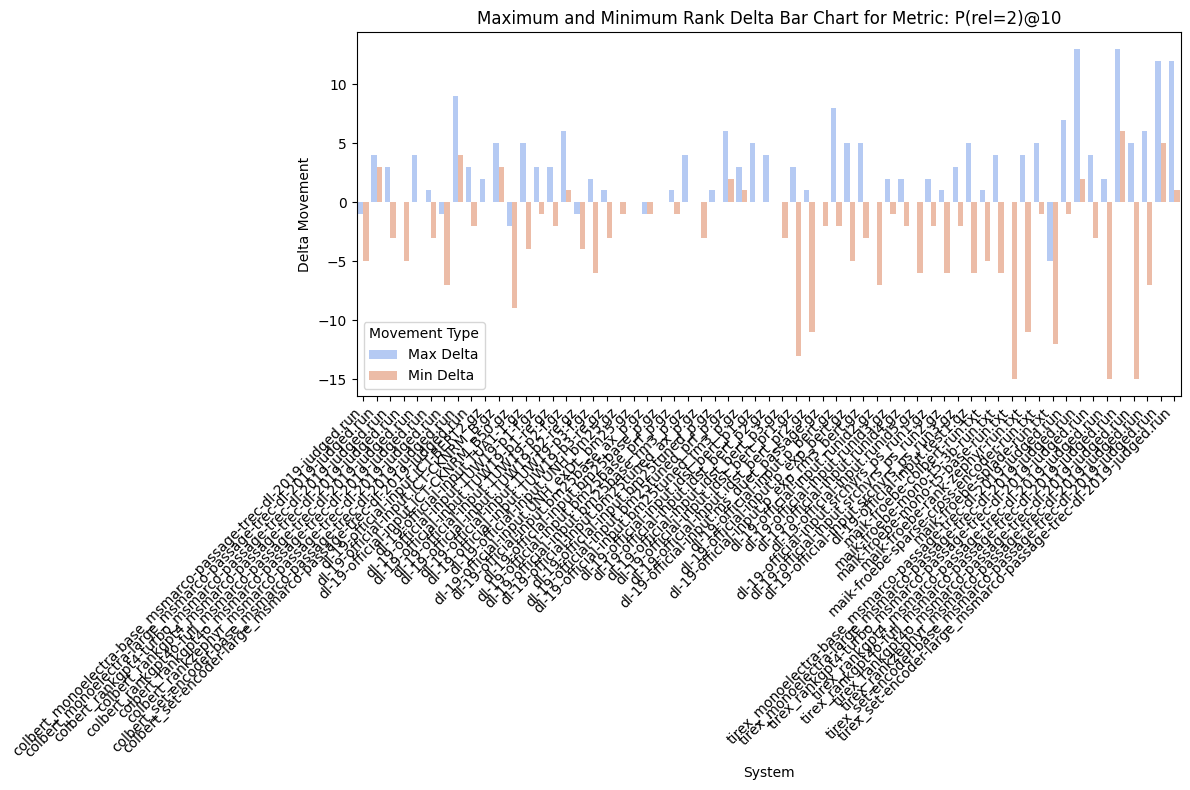

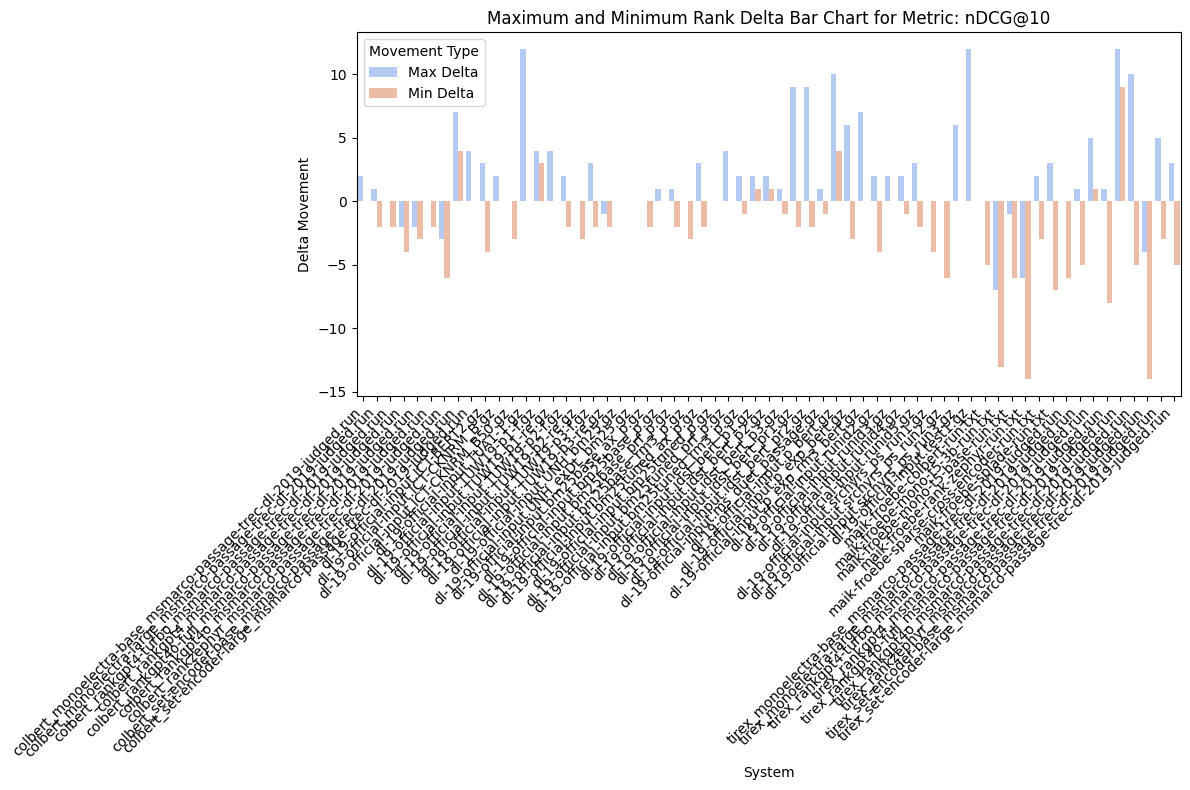


100%|██████████| 61/61 [00:27<00:00, 16.82it/s]

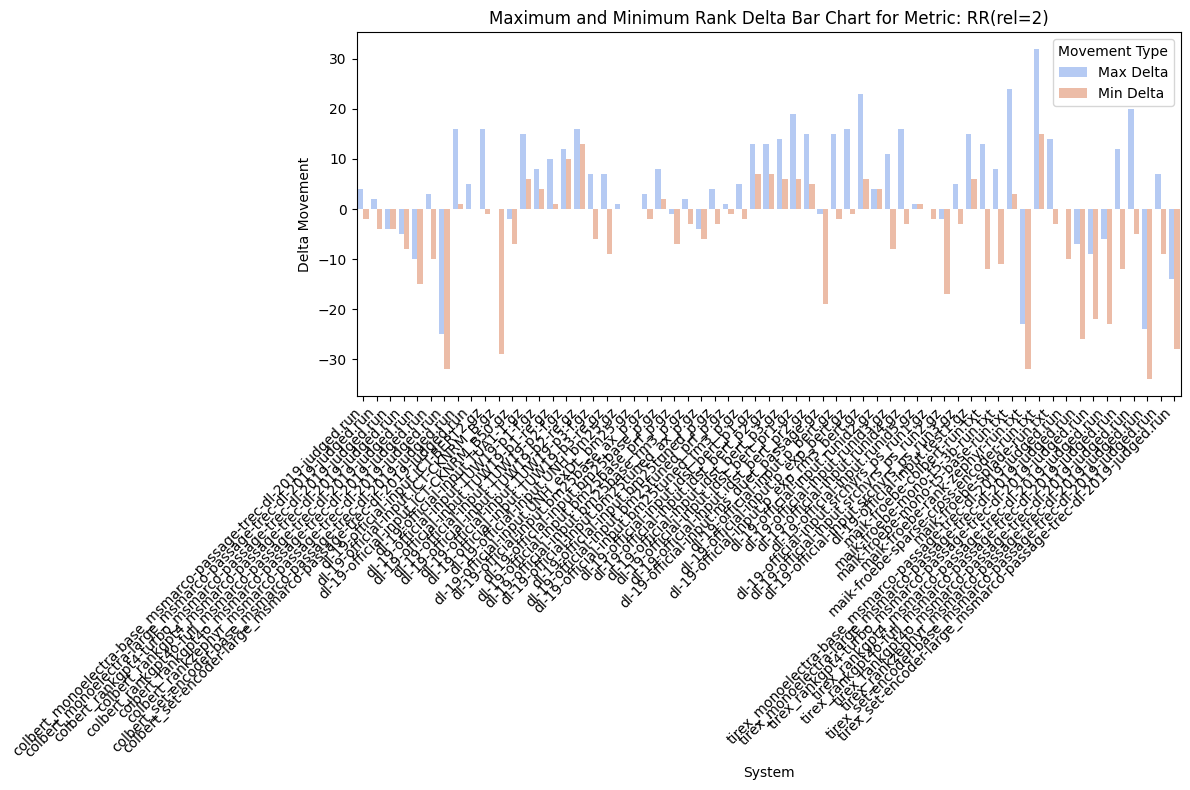

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Extract the maximum and minimum rank delta for each system per metric
movements = []

for system in system_rank_deltas:
    for metric in set(metric for annotator in system_rank_deltas[system] for metric in system_rank_deltas[system][annotator]):
        deltas = []
        
        for annotator in system_rank_deltas[system]:
            if metric in system_rank_deltas[system][annotator]:
                deltas.append(system_rank_deltas[system][annotator][metric])
        
        max_delta = max(deltas) if deltas else None  # Maximum movement for the system in this metric
        min_delta = min(deltas) if deltas else None  # Minimum movement for the system in this metric
        
        movements.append([system, metric, max_delta, min_delta])

# Step 2: Convert to DataFrame for bar charts
df_movements = pd.DataFrame(movements, columns=['System', 'Metric', 'Max Delta', 'Min Delta'])

# Step 3: Create unique metrics for separate bar charts
unique_metrics = df_movements['Metric'].unique()

# Step 4: Plot bar charts for each metric
for metric in unique_metrics:
    # Filter data for the current metric
    metric_data = df_movements[df_movements['Metric'] == metric]
    
    # Melt the DataFrame for easier plotting
    metric_melted = metric_data.melt(id_vars=['System'], value_vars=['Max Delta', 'Min Delta'], 
                                       var_name='Movement Type', value_name='Delta')

    # Plot bar chart
    plt.figure(figsize=(12, 8))
    sns.barplot(data=metric_melted, x='System', y='Delta', hue='Movement Type', palette='coolwarm', dodge=True)

    # Rotate the system names for better readability
    plt.xticks(rotation=45, ha='right')

    # Add title and labels
    plt.title(f'Maximum and Minimum Rank Delta Bar Chart for Metric: {metric}')
    plt.xlabel('System')
    plt.ylabel('Delta Movement')

    # Show the plot
    plt.tight_layout()
    plt.show()


In [31]:
import pandas as pd

# Step 1: Create a dictionary to store improvements and degradations
rank_changes = {system: {metric: {'improved': 0, 'degraded': 0} for metric in set(metric for annotator in system_rank_deltas[system] for metric in system_rank_deltas[system][annotator])} for system in system_rank_deltas}

# Step 2: Calculate improvements and degradations for each system per metric
for system in system_rank_deltas:
    for metric in rank_changes[system]:
        for annotator in system_rank_deltas[system]:
            if metric in system_rank_deltas[system][annotator]:
                delta = system_rank_deltas[system][annotator][metric]
                
                if delta < 0:
                    rank_changes[system][metric]['improved'] += 1
                elif delta > 0:
                    rank_changes[system][metric]['degraded'] += 1

# Step 3: Convert the rank_changes dictionary to a DataFrame
data = []

for system, metrics in rank_changes.items():
    row = {'System': system}
    for metric, changes in metrics.items():
        row[f'{metric}_Improved'] = changes['improved']
        row[f'{metric}_Degraded'] = changes['degraded']
    data.append(row)

# Create DataFrame from the list of rows
df_rank_changes = pd.DataFrame(data)

# Step 4: Add a final row for the total improvements and degradations across all metrics
totals = {'System': 'Total'}
for column in df_rank_changes.columns[1:]:  # Skip 'System' column
    totals[column] = df_rank_changes[column].sum()

# Convert totals dictionary to a DataFrame and concatenate with the original DataFrame
totals_df = pd.DataFrame([totals])

# Concatenate the totals row
df_rank_changes = pd.concat([df_rank_changes, totals_df], ignore_index=True)

# Step 5: Display the final DataFrame
df_rank_changes


,System,R(rel=2)@100_Improved,R(rel=2)@100_Degraded,AP(rel=2)_Improved,AP(rel=2)_Degraded,RR(rel=2)@10_Improved,RR(rel=2)@10_Degraded,P(rel=2)@10_Improved,P(rel=2)@10_Degraded,nDCG@10_Improved,nDCG@10_Degraded,RR(rel=2)_Improved,RR(rel=2)_Degraded
0,colbert_monoelectra-base_msmarco-passage-trec-...,0,0,16,0,2,9,16,0,0,15,8,7
1,colbert_monoelectra-large_msmarco-passage-trec...,0,0,7,8,16,0,0,16,6,7,11,3
2,colbert_rankgpt4-turbo_msmarco-passage-trec-dl...,0,0,16,0,16,0,9,5,14,0,16,0
3,colbert_rankgpt4_msmarco-passage-trec-dl-2019-...,0,0,16,0,16,0,14,0,16,0,16,0
4,colbert_rankgpt4o-full_msmarco-passage-trec-dl...,0,0,12,0,16,0,0,7,16,0,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,tirex_rankgpt4o_msmarco-passage-trec-dl-2019-j...,16,0,11,2,3,13,8,6,2,14,2,13
58,tirex_rankzephyr_msmarco-passage-trec-dl-2019-...,5,4,16,0,16,0,8,6,16,0,16,0
59,tirex_set-encoder-base_msmarco-passage-trec-dl...,0,16,14,2,3,13,0,16,7,8,10,5
60,tirex_set-encoder-large_msmarco-passage-trec-d...,0,16,10,4,16,0,0,16,10,2,16,0


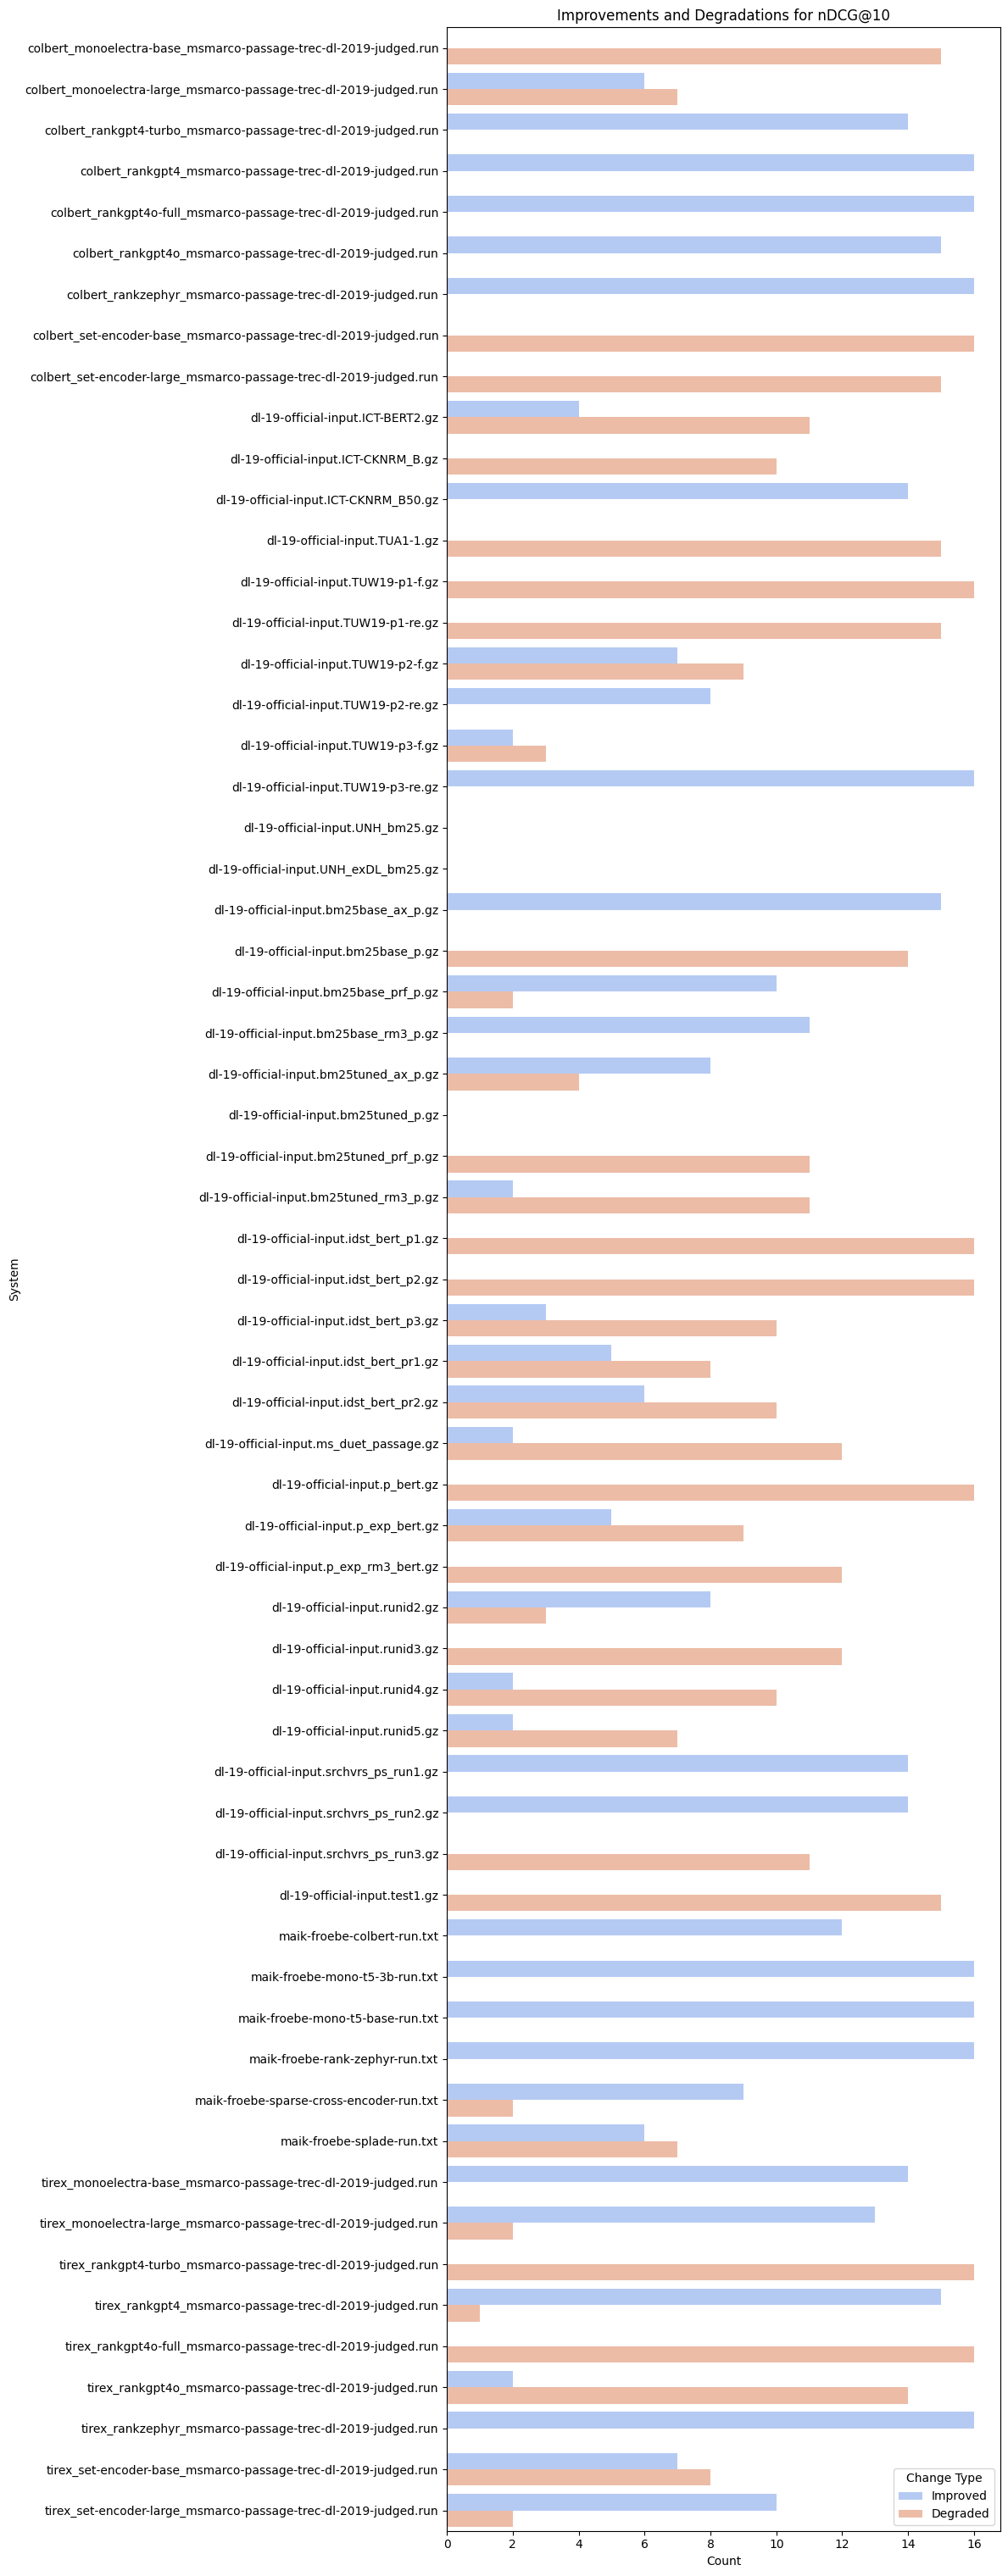

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Filter data for the specific metric (nDCG@10)
metric_of_interest = 'nDCG@10'
data = []

for system, metrics in rank_changes.items():
    row = {'System': system}
    if metric_of_interest in metrics:
        row['Improved'] = metrics[metric_of_interest]['improved']
        row['Degraded'] = metrics[metric_of_interest]['degraded']
    data.append(row)

# Convert the filtered data into a DataFrame
df_improve_degrade = pd.DataFrame(data)

# Step 2: Melt the DataFrame to long format for easier plotting
df_melted = df_improve_degrade.melt(id_vars='System', value_vars=['Improved', 'Degraded'], 
                                    var_name='Change Type', value_name='Count')

# Step 3: Create a horizontal stacked bar plot
plt.figure(figsize=(12, len(df_improve_degrade) * 0.5))  # Adjust height based on the number of models
sns.barplot(data=df_melted, y='System', x='Count', hue='Change Type', palette='coolwarm', orient='h')

# Rotate the system names for better readability if necessary
plt.title(f'Improvements and Degradations for {metric_of_interest}')
plt.xlabel('Count')
plt.ylabel('System')

# Show the plot
plt.tight_layout()
plt.show()
